In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Test pipeline on one instance


In [56]:
from pathlib import Path
import librosa
import IPython.display as ipd
from pitch_estimator import PitchEstimator
from preprocessors import Preprocessor
import matplotlib.pyplot as plt
import scipy
import numpy as np

In [13]:
data_path = Path("gamelan_music_dataset")
targets_first = data_path / "first ensemble/orchestra/target"
audio_file_path = targets_first / "demung/001.wav"

pitch_est = PitchEstimator()
pp = Preprocessor()

# Display input audio
y, sr = librosa.load(audio_file_path, duration=10)
print('Input audio:')
display(ipd.Audio(y, rate=sr))

# Using median filtering to divide harmonic from percussive component
spectrogram = pp.compute_spectrogram(y)
harmonic = pp.apply_median_filtering(spectrogram)

# Reconstruct harmonic component audio and display it
reconstructed_audio = librosa.istft(harmonic)
# what about the phase? this reconstruction is bulshit
print('Harmonic component reconstructed with inverse STFT:')
display(ipd.Audio(reconstructed_audio, rate=sr))


# Reconstruct harmonic component audio and display it
reconstructed_audio_griffinlim = librosa.griffinlim(harmonic)
# https://librosa.org/doc/main/generated/librosa.griffinlim.html
print('Harmonic component reconstructed with griffin and lim algorithm:')
display(ipd.Audio(reconstructed_audio_griffinlim, rate=sr))


Input audio:


Harmonic component reconstructed with inverse STFT:


Harmonic component reconstructed with griffin and lim algorithm:


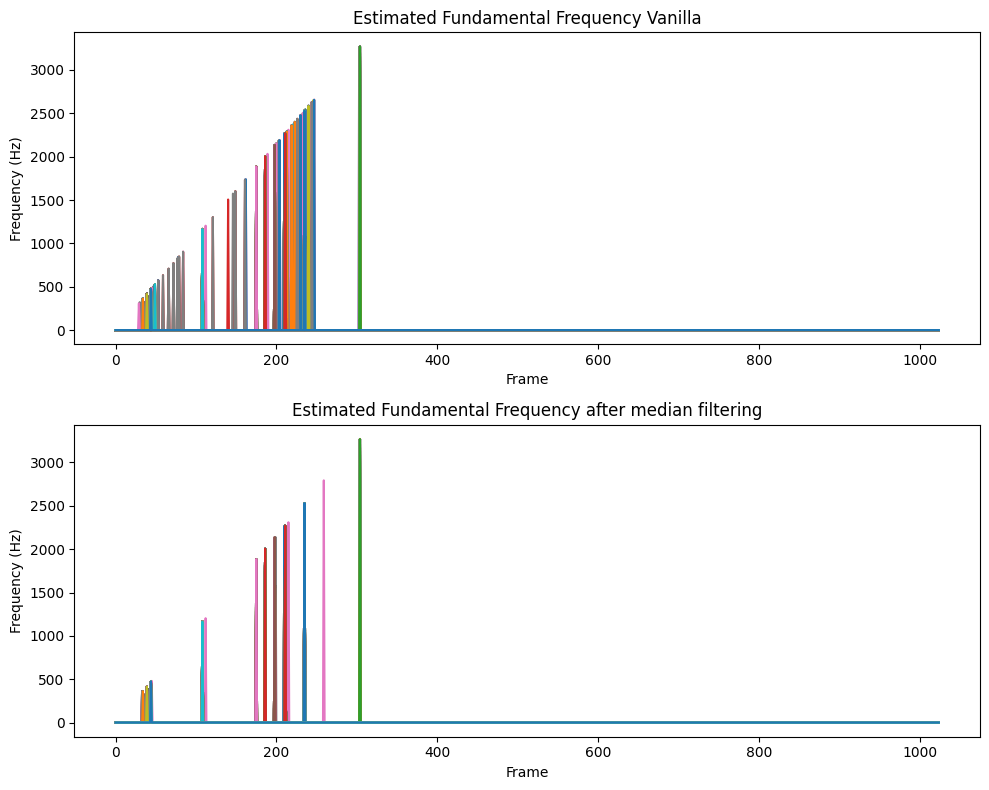

In [37]:
# activations = pp.apply_NMF(spectrogram)
pitches, magnitudes = pitch_est.estimate_dsp(spectrogram, sr)

harm_pitches, harm_magnitudes = pitch_est.estimate_dsp(harmonic, sr)

plt.figure(figsize=(10, 8))

# Plotting the first subplot
plt.subplot(2, 1, 1)
plt.plot(pitches)
plt.xlabel('Frame')
plt.ylabel('Frequency (Hz)')
plt.title('Estimated Fundamental Frequency Vanilla')

# Plotting the second subplot
plt.subplot(2, 1, 2)
plt.plot(harm_pitches)
plt.xlabel('Frame')
plt.ylabel('Frequency (Hz)')
plt.title('Estimated Fundamental Frequency after median filtering')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()



Filtered Frequencies:


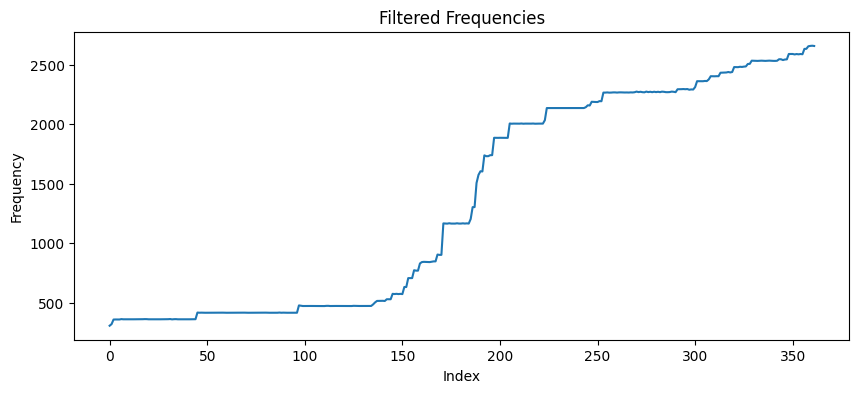

In [29]:

# Set the threshold for discarding very low or very high frequencies
threshold_low = 90  # Minimum frequency threshold
threshold_high = 3000  # Maximum frequency threshold

# Flatten the pitches array to make it 1-dimensional
pitches_flat = pitches.flatten()

# Find the peaks in the pitches
peaks, _ = scipy.signal.find_peaks(pitches_flat)

# Filter the peaks based on the threshold
filtered_peaks = [peak for peak in peaks if threshold_low <= pitches_flat[peak] <= threshold_high]

# Get the frequencies of the filtered peaks
filtered_frequencies = pitches_flat[filtered_peaks]

# Display the filtered frequencies
print("Filtered Frequencies:")
plt.figure(figsize=(10, 4))
plt.plot(filtered_frequencies)
plt.xlabel('Index')
plt.ylabel('Frequency')
plt.title('Filtered Frequencies')
plt.show()

In [44]:
time, frequency, confidence, activation = pitch_est.estimate_crepe(reconstructed_audio_griffinlim, sr)


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step


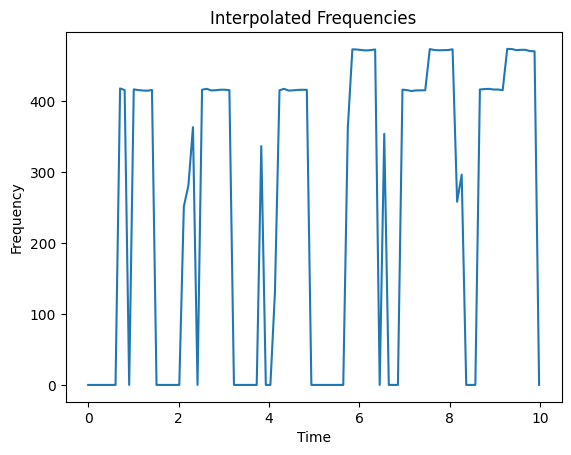

In [69]:
# lol 🥲 it looks weird 
# we could implement a count of occurences of frequency, after a certain 
# lets say: what are the most repeated values?
# does it make sense?

# mmm,, i would start by flatten everything, as there is some variance even when it is a straight line

# looks ugly 🫠






frequency[confidence < 0.9] = 0

# Create a function to interpolate the frequencies
interpolated_frequency = scipy.interpolate.interp1d(time, frequency, kind='linear')

# Generate a new set of time values for smoother lines
new_time = np.linspace(time.min(), time.max(), num=100)

# Interpolate the frequencies using the new time values
new_frequency = interpolated_frequency(new_time)

# Plot the interpolated frequencies
plt.plot(new_time, new_frequency)
plt.xlabel('Time') 
plt.ylabel('Frequency')
plt.title('Interpolated Frequencies')
plt.show()